# MVA - "Méthodes de séparation de sources pour l’analyse de données en astrophysique"

Hugo SIMON & Théophile RAGEAU

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Project_BSS/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Project_BSS


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import scipy.io as sio
import sklearn

import Starlet2D as st2
from fichiers_utils import plot_train_test_loss, NMSE, correctPerm, My_dataset
from methods import PALM, ISTA_S, NSISTA_S, simpleSPA, minvolNMF, pGMCA
from utils import plotAS

%matplotlib inline

# I Problématique

Dans ce projet, nous étudions un problème de séparation de sources sur des données astronomiques de rémanent de supernova. Le problème consiste à factoriser une matrice $\mathbf X$ contenant des observations en deux matrices $\mathbf  A$ et $\mathbf S$, respectivement matrice de mélange et matrice des sources, de la façon suivante : $\mathbf X = \mathbf{AS}$.

Nous nous intéressons ici aux émissions de Fer *red-shifted* (décalées vers les basses fréquences), *blue-shifted* (décalées vers les hautes fréquences) ainsi qu'au rayonnement synchrotron.

Pour étudier ce phénomène, les trois jeux de données suivants nous sont fournis :
 - **LinModel** : un jeu de données simulé dans lequel les émissions du Fer et du rayonnement synchrotron ont été modélisées
 - **ComplexSims** : un jeu de données simulé dans lequel la matrice de mélange est non-stationnaire, c'est-à-dire qu'elle dépend du pixel considéré
 - **RealData** : jeu de données réel
  
Les bandes d'émissions du Fer et du synchrotron sont les mêmes pour les trois jeux. De plus, un bruit de Poisson y est présent dans chacun. La figure ci-dessous montre la matrice de mélange simulée ainsi que les sources pour le jeu de données **LinModel**.

### SHAPES ###

First dataset :
LinModel : (40, 128, 128)
MixingMatrix : (40, 3)
Sources : (3, 128, 128)

Second dataset :
ComplexSims : (40, 230, 230)

Third dataset :
RealData : (40, 256, 256)

### PLOT MIXING MATRIX AND SOURCES ###


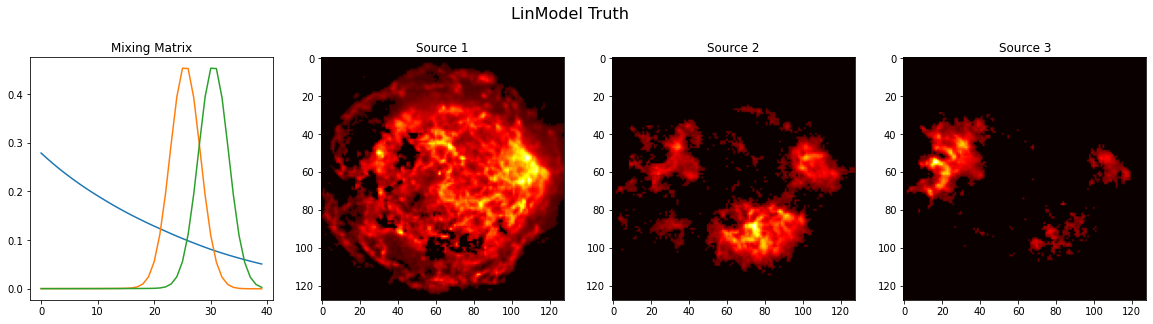

In [ ]:
# @title Plot Mixtures {vertical-output: true}
chandra = np.load("./chandra_data.npy", allow_pickle=True)
LinModel = chandra.item()['LinModel']
MixingMatrix = chandra.item()['MixingMatrix']
Sources = chandra.item()['Sources']
ComplexSims = chandra.item()['ComplexSims']
RealData = chandra.item()['RealData']

print('### SHAPES ###\n')
print('First dataset :')
print(f'LinModel : {LinModel.shape}')
print(f'MixingMatrix : {MixingMatrix.shape}')
m, n = MixingMatrix.shape
print(f'Sources : {Sources.shape}\n')

print('Second dataset :')
print(f'ComplexSims : {ComplexSims.shape}\n')

print('Third dataset :')
print(f'RealData : {RealData.shape}\n')

print('### PLOT MIXING MATRIX AND SOURCES ###')
plotAS(MixingMatrix, Sources**0.5, "LinModel Truth", cmap="hot")



# II Un essai introductif

Dans cette première partie, nous appliquons à chacun des jeux de données l'algorithme d'optimisation PALM (Proximal Alternating Linearized Minimization) avec une contrainte de positivité. Cette hypothèse est conservée dans la suite car on cherche à déterminer des spectres d’émission (matrice de mélange) et des concentrations (sources) donc uniquement des grandeurs positives. La figure ci-dessous montre les résultats obtenus pour les matrices de mélanges.

Pour chacun de ces jeux de données, on remarque que la structure globale de la matrice de mélange est conservée, on retrouve bien les trois spectres d'émissions recherchés.
Pour le jeu de données **LinModel**, que l'on peut considérer comme le plus simple des trois proposés, on remarque certains défauts d'approximation de la matrice de mélange par rapport à celle initiale. De plus, ces défauts sont présents et même accentués dans les deux autres jeux (**ComplexSims** et **RealData**). Nous revenons plus en détails sur ces défauts d'approximation dans la partie suivante.

Suite à cette première approche, on peut dire que la séparation de sources classique avec pour seule hypothèse la positivité des matrices $\mathbf{A}$ et $\mathbf{S}$ ne fournis pas de résultats totalement satisfaisants. 



In [ ]:
#@title Estimation with PALM
Datas = [LinModel, ComplexSims, RealData]
As_est, Ss_est, criterions = [], [], []
for Data in Datas:
    m, t1, t2 = Data.shape
    X = Data.reshape(m, -1)
    A_est, S_est, criterion = PALM(X, n, itmax=2000, Ainit=MixingMatrix, Sinit=None)
    As_est.append(A_est)
    Ss_est.append(S_est.reshape(n ,t1, t2))
    criterions.append(criterion)

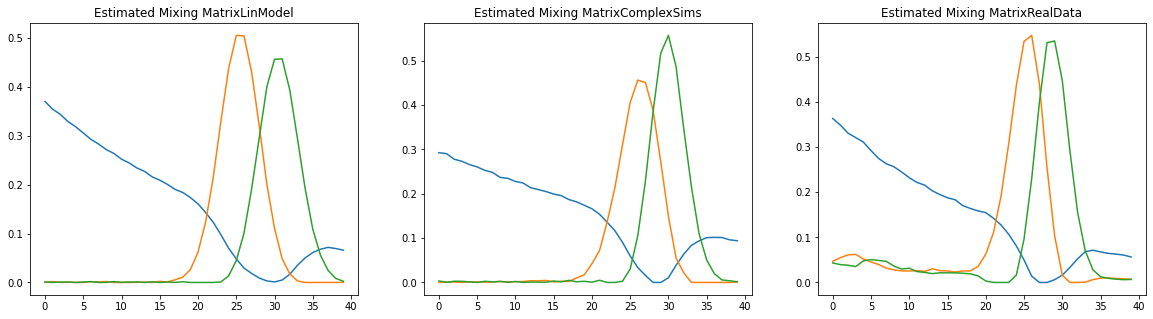

In [ ]:
plt.figure(figsize = (20, 5))
titles = ["LinModel", "ComplexSims", "RealData"]
for i in range(len(Datas)):
    plt.subplot(1,len(Datas),i+1)
    plt.plot(As_est[i])
    plt.title('Estimated Mixing Matrix'+titles[i])

# III Minimum Volume NMF

Dans cette partie, nous nous intéressons aux performances de l'algorithme de Minimum Volume NMF vu en cours, appliqué à notre problème de démélange. 
Cet algorithme nous permet d'imposer une autre contrainte de type géométrique en plus de la positivité.

Nous initialisons cet algorithme avec une matrice de mélange obtenue par l'algorithme SPA (Successive Projection Algorithm). Cet algorithme a l'avantage de retourner une solution rapide et relativement fidèle au résultat que l'on souhaite obtenir. L'algorithme de Minimum Volume permet d'affiner ensuite ces résultats.

De la même manière que pour l'algorithme PALM dans la partie précédente, nous testons l'algorithme de Minimum Volume NMF sur les trois jeux de données fournis.

In [ ]:
#@title Estimation with PALM
Datas = [LinModel, ComplexSims, RealData]
As_est, Ss_est = [], []
for Data in Datas:
    m, t1, t2 = Data.shape
    X = Data.reshape(m, -1)

    K_SPA = simpleSPA(X, n)
    W = X[:, K_SPA]
    H = np.fmax(np.random.rand(n, np.shape(X)[1]), 1e-2)
    W_t, H_t, e_t, er1_t, er2_t = minvolNMF(X, n, W, H, lamb = 1., maxiter = 1000, target = 0.05, model = 1)

    Wc1, indPerm = correctPerm(MixingMatrix, W_t)
    Hc = H_t[indPerm, :]
    As_est.append(Wc1)
    Ss_est.append(Hc.reshape(n ,t1, t2))

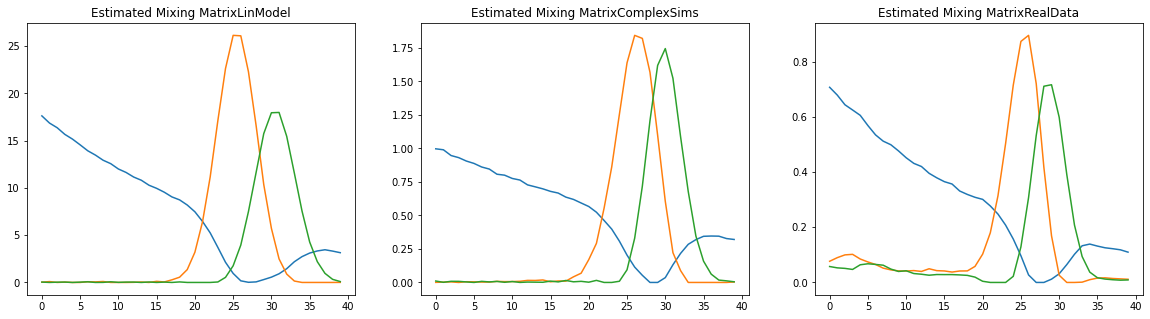

In [ ]:
plt.figure(figsize = (20, 5))
titles = ["LinModel", "ComplexSims", "RealData"]
for i in range(len(Datas)):
    plt.subplot(1,len(Datas),i+1)
    plt.plot(As_est[i])
    plt.title('Estimated Mixing Matrix'+titles[i])

Pour chacun des trois jeux de données, on remarque que l'algorithme parvient bien à discerner les différents spectres d'émission (synchrotron, *blue-shift* et *red-shift* du Fer). On distingue assez clairement les deux raies d'émission du fer modélisées par des gaussiennes de moyennes assez proches et le rayonnement synchrotron décroissant globalement sur la bande d'énergie. 

Cependant, on retrouve pour les 3 jeux de données un creux dans le spectre du synchrotron au niveau des raies d'émissions de Fer, qui n'est pas présent dans la matrice de mélange initiale (On notera aussi que les gaussiennes correspondant aux raies d'émission du Fer diffèrent d'un facteur d'échelle). De plus, pour **RealData**, la queue de distribution des émissions du Fer ne tendent pas vers 0.

Nous allons dans les parties suivantes prendre en compte de nouvelles hypothèses (non-stationnarité et bruit de Poisson) et adapter les méthodes développées jusqu'ici de manière à corriger les défauts d'approximation évoqués précédemment.

# IV Modèle non-stationnaire

On observe dans les essais précédents que la matrice de mélange à considérer est sensiblement la même dans les 3 jeux de données. Cela est dû à la réalité physique sous-jacente dans laquelle la nébuleuse considérée admet, pour la plage d'énergie considérée :
* un rayonnement synchrotron qui suit une loi de puissance.
* une raie d'émission Fer qui selon la direction et la vitesse d'expansion relative à l'observateur apparait décalée vers le rouge (resp. bleu) en s'éloignant (resp. se rapprochant). Un modèle Gaussien traduit la variabilité des vitesses relatives et la réponse impulsionnelle du téléscope.

On peut donc supposer ces rayonnements comme étant donnés et appliquer un algorithme de séparation de source non-aveugle (NBSS) comme ISTA.

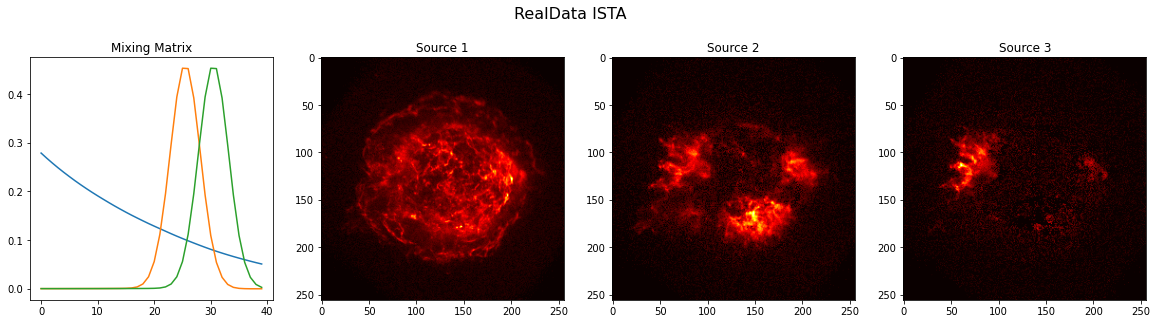

In [ ]:
#@title Estimation with ISTA {vertical-output: true}
Data = RealData
_, t1, t2 = Data.shape
X = Data.reshape(m, -1)
S_est, criterions = ISTA_S(X, MixingMatrix, lamb = 0.1, itmax = 500, Sinit=None)
S_est = S_est.reshape(n ,t1, t2)
plotAS(MixingMatrix, S_est**0.5, "RealData ISTA")

Or même en supposant la vitesse d'expansion du rémanent de supernova homogène, la vitesse relative à l'observateur peut varier. On se propose de construire un modèle non-stationnaire dans lequel chaque pixel observé admet une matrice de mélange différente.

On commence par estimer les paramètres du modèle linéaire, c'est à dire les espérances$ \bar f_{bs}$ et $\bar f_{rs}$et la variance $\sigma^2_{bs}$ et $\sigma^2_{rs}$ des Gaussiennes du modèle. Ensuite, on sait que la fréquence reçue $f_{rec}$ est donnée par la loi de Doppler-Fizeau $f_{rec} = \frac 1 {1-\frac {v_{rel}} c}f_{em}$ où la vitesse relative $v_{rel}$ est prise positive dans le sens de l'émission.

Dans le cas où on supposerait uniquement 2 émissions radiales, on aurait

$$\begin{cases} 
f_{bs} = \frac 1 {1-\frac {v_{rel}} c} f_{em} \\
f_{rs} = \frac 1 {1+\frac {v_{rel}} c} f_{em} 
 \end{cases} \iff \begin{cases} 
\frac {v_{rel}} c = \frac {f_{bs} - f_{rs}} {f_{bs} + f_{rs}}\\
f_{em} = \frac 2 {1/f_{bs} + 1/f_{rs}} \quad \text{(i.e. la moyenne harmonique)}
 \end{cases} $$


Or on suppose une expulsion sphérique des gaz. Par trigonométrie, on a que
$v_{rel} = v_{em} \alpha(d/R) = v_{em} \sqrt{(1-(d/R)^2)_+}$ où alpha est un coefficient qui dépend uniquement du ratio distance au centre de l'image/Rayon de la sphère sur l'image. Le décalage vers le rouge/bleu total est la moyenne des décalages sur l'ensemble des points de l'image :

 $$\begin{cases} 
\bar f_{bs} = \mathbb E[\frac 1 {1-\frac {v_{rel}} c}f_{em}] \simeq (1+ \frac {v_{em}} c {\mathbb E[\alpha]}) f_{em}  \\
\bar f_{rs} \simeq (1 - \frac {v_{em}} c {\mathbb E[\alpha]}) f_{em}
 \end{cases} \iff \begin{cases} 
\frac {v_{em}} c = \frac 1 {\mathbb E[\alpha]} \frac {\bar f_{bs} - \bar f_{rs}} {\bar f_{bs} + \bar f_{rs}}\\
f_{em} = \frac {\bar f_{bs} + \bar f_{rs}} 2 
 \end{cases} $$

 Aussi la variance totale est la somme de la variances dû à la variabilité des vitesses relatives et la variance de la réponse impulsionnelle du téléscope i.e. $\sigma^2_{rs} \simeq \sigma^2_{bs} \simeq \sigma^2_{telescope} + \mathbb Var[\frac 1 {1-\frac {v_{em}} c \alpha}f_{em}]$

On construit ainsi le tenseur de mélange
$$A_{t,m,n} = \begin{cases}
\text{si } n=0, \quad \forall t, \text{ le rayonnement synchrotron}\\
\text{si } n=1, \quad\mathcal N(\frac 1 {1+\frac {v_{em}} c \alpha(t)}f_{em}, \sigma^2_{telescope})\\
\text{si } n=2,\quad  \mathcal N(\frac 1 {1-\frac {v_{em}} c \alpha(t)}f_{em}, \sigma^2_{telescope})
\end{cases}$$

Et notre modèle génératif non-stationnaire devient
$$X_{m,t} = \sum_{k=1}^n A_{t,m,k} S_{k,t}$$


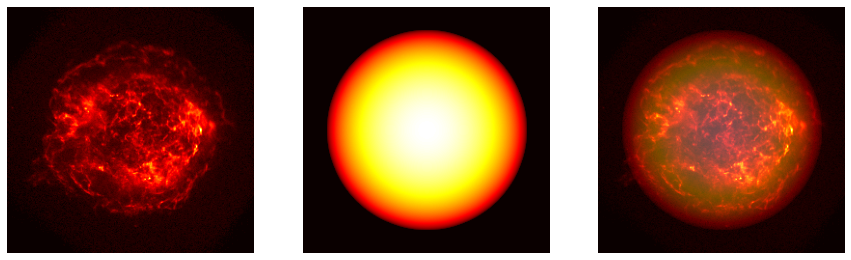

In [ ]:
EnergyMap = np.sum(Data, axis=0)
middle = np.array([t2, t1])//2
Radius = middle[0]*13//16
alphas = np.zeros((t1,t2))
for i in range(t1):
    for j in range(t2):
        coord = np.array([i, j])
        radius = np.linalg.norm(coord - middle)
        alphas[i,j] = np.sqrt(np.maximum(0, 1 - (radius / Radius)**2))

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(EnergyMap**0.5, cmap="hot"), plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(alphas, cmap="hot"), plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(EnergyMap**0.5, cmap="hot"), plt.axis('off')
plt.imshow(alphas, cmap="hot", alpha=0.3), plt.axis('off');

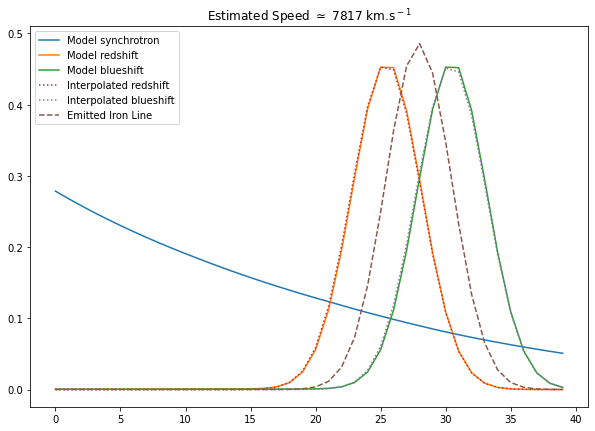

In [ ]:
#@title Parameter Estimation {vertical-output: true}
from scipy.stats import multivariate_normal
masses = np.sum(MixingMatrix[:,1:], axis=0)
densities = MixingMatrix[:,1:]/masses
means = np.sum([i*densities[i] for i in range(m)], axis=0)
vars = np.sum([(i-means)**2*densities[i] for i in range(m)], axis=0)
vars -= np.array([0.7,1])

range_a, range_b = means
keV_a, keV_b = 5.65, 5.85
def to_keV(x):
    return (x-range_a)/(range_b-range_a)*(keV_b-keV_a)+keV_a
def to_range(x):
    return (x-keV_a)/(keV_b-keV_a)*(range_b-range_a)+range_a

alphas_nz = alphas.ravel()
alphas_nz = alphas_nz[alphas_nz>0]
mean_alpha = alphas_nz.mean()
means_keV = to_keV(means)

speed_em = (1 / mean_alpha) * (means_keV[1] - means_keV[0]) / (means_keV[1] + means_keV[0])
mean_em, mass_em = means.mean(), masses.mean()
var_em = vars.mean() - np.var(to_range(1/(1-speed_em*alphas_nz)*to_keV(mean_em)))

plt.figure(figsize=(10,7))
labels = ["Model synchrotron", "Model redshift", "Model blueshift"]
plt.plot(MixingMatrix, label=labels)
labels = ["Interpolated redshift", "Interpolated blueshift"]  
for i in range(2):
    plt.plot(multivariate_normal.pdf(range(m), means[i], vars[i])*masses[i], ':', label=labels[i])
plt.plot(multivariate_normal.pdf(range(m), mean_em, var_em)*mass_em, '--', label="Emitted Iron Line")
plt.title(f"Estimated Speed $\simeq$ {speed_em * 300000:.0f} km.s$^-$$^1$")
plt.legend();

In [ ]:
NSMixingMatrix = np.zeros((t1*t2, *MixingMatrix.shape))
for i in range(t1):
    for j in range(t2):
        speed_rel = speed_em * alpha[i,j]
        means_rel = to_range(to_keV(mean_em) * np.array([1 / (1 + speed_rel), 1 / (1 - speed_rel)]))
        redshift = multivariate_normal.pdf(range(m), means_rel[0], var_em)*masses[0]
        blueshift = multivariate_normal.pdf(range(m), means_rel[1], var_em)*masses[1]
        NSMixingMatrix[i*t1+j,:,0] = MixingMatrix[:,0]
        NSMixingMatrix[i*t1+j,:,1] = redshift
        NSMixingMatrix[i*t1+j,:,2] = blueshift

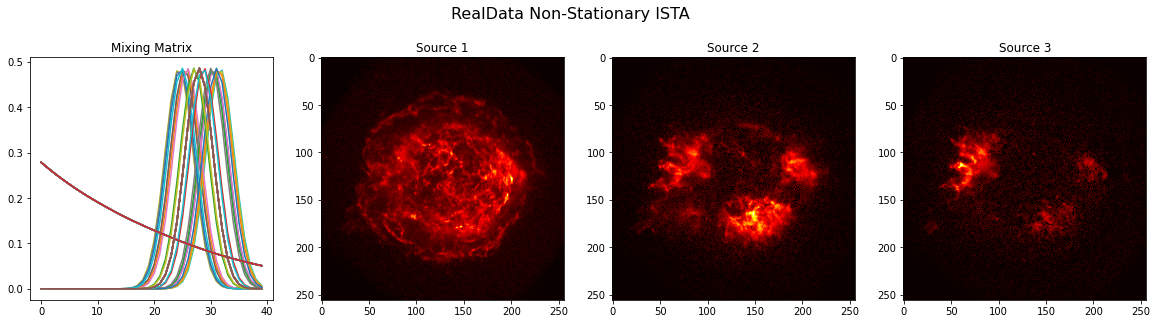

In [ ]:
#@title Estimation with NSISTA {vertical-output: true}
S_est, criterions = NSISTA_S(X, NSMixingMatrix, lamb = 0.1, itmax=500)
S_est = S_est.reshape(n ,t1, t2)
plotAS(np.concatenate(NSMixingMatrix[::3000], axis=1), S_est**0.5, "RealData Non-Stationary ISTA")

On observe une meilleure estimation de la source 3 que celle obtenue par ISTA, au sens où des régions dans lesquelles il existe a priori du Fer décalé vers le bleu sont mieux détectées. Le gain du modèle non-stationnaire n'est pas en soi remarquable comparativement au modèle stationnaire ce qui justifie que l'on se concentre sur un modèle stationnaire dans la suite. Ce qui fait cependant pleinement défaut dans les exemples précédents est la présence systématique de bruit Poissionnien. C'est à sa prise en compte que nous allons oeuvrer.

# V Prise en compte du bruit de Poisson

Les méthodes de séparation de sources étudiées et testées précédemment ne prennent pas en compte le bruit de Poisson appliqué aux données. Dans le cas des jeux de données **LinModel** et **ComplexSim**, ce bruit est simulé, tandis que pour les données réelles, ce bruit est obtenu lors de l’acquisition des images astronomiques.
Pour pouvoir prendre en compte cette hypothèse importante, nous avons implémenté une variante de l’algorithme GMCA (Generalized Morphological Component Analysis) nommé pGMCA (Poisson Generalized Morphological Component Analysis) en nous basant sur l’article intitulé [Sparse BSS from Poisson Measurements ](https://hal.archives-ouvertes.fr/hal-02083157/document?fbclid=IwAR1zZkNsffQzboggBeIFcIGPQfL3keX6JPQnvKtIw3S7_ZtMT2B8HR-BLSA) de J. Bobin et al. publié en 2019. Cet article décrit l’idée de l’algorithme, son fonctionnement et en détaille son implémentation.
Nous allons dans cette partie résumer les grandes lignes de cet article et présenter les résultats obtenus par son utilisation.

L’algorithme pGMCA consiste en la résolution du problème d’optimisation suivant :

$$ \min _{\mathbf{A} \in \mathcal{C}, \alpha \boldsymbol{\Phi} \geq 0}\|\boldsymbol{\Lambda} \odot \alpha\|_{\ell_{1}}+\mathcal{L}_{\mu}(\mathbf{X} \mid \mathbf{A}, \alpha \boldsymbol{\Phi}) $$

Dans cette équation $\alpha$ correspond à la transformée dans une base d'ondelettes de nos sources $\mathbf{S}$, $\mathcal{L}_{\mu}(\mathbf{X} \mid \mathbf{A}\mathbf{S})$ correspond à une approximation différentiable de la log-vraisemblance de Poisson de nos données et l’ensemble $\mathcal{C}$ est l’intersection de l’orthan positif $K^+$ et de la boule unité $O_b$ pour la norme $l_2$. De plus, ce problème d’optimisation n’est pas convexe par rapport $(\alpha, A)$ mais l’est par rapport à chacune des deux variables $\alpha$ et $A$ séparément.

Il est possible d’obtenir une approximation de la solution de ce problème en utilisant un algorithme BCD (Block Coordinate Descent). On va ainsi mettre à jour alternativement chacune des variables $S$ et $A$ en considérant les deux sous-problèmes suivants :

Mise à jour de $\mathbf{S}$ :
$$ \min _{\alpha}\|\boldsymbol{\Lambda} \odot \alpha\|_{\ell_{1}}+\iota_{K^{+}}(\alpha \boldsymbol{\Phi})+\mathcal{L}_{\mu}(\mathbf{X} \mid \mathbf{A}, \alpha \boldsymbol{\Phi}) $$ 


Mise à jour de $\mathbf{A}$ :
$$ \min _{\mathbf{A}} \iota_\mathcal{C}(\mathbf{A}) + \mathcal{L}_{\mu}(\mathbf{X} \mid \mathbf{A}, \mathbf{S}) $$

Dans le premier problème, on considère la somme de deux contraintes non-différentiables qui admettent respectivement un opérateur proximal analytique, mais dont la somme n'en admet pas. On utilise donc un algorithme GFBS (Generalized Forward-Backward Splitting) qui permet de traiter les opérateurs proximaux $\operatorname{prox}_{l_1} = \mathcal{S_{\lambda}}$ et $\operatorname{prox}_{K^+} = \max(., 0)$ de façon indépendante.

Dans le second problème, on considère des matrices de mélange $A$ dans l’intersection de deux ensembles convexes $K^+$ et $O_b$. Dans ce cas, la projection d’un élément dans l’intersection de ces deux ensembles est la composition des deux opérateurs proximaux $\operatorname{prox}_{O_b} \circ \operatorname{prox}_{K^+}$. On résout ce problème grâce à un algorithme de type FBS (Forward-Backward Splitting).

In [ ]:
S_est, A_est, criterions = pGMCA(RealData, MixingMatrix, iter=150, iter_gmca=100, iter_gfbs=2, iter_fista=10)

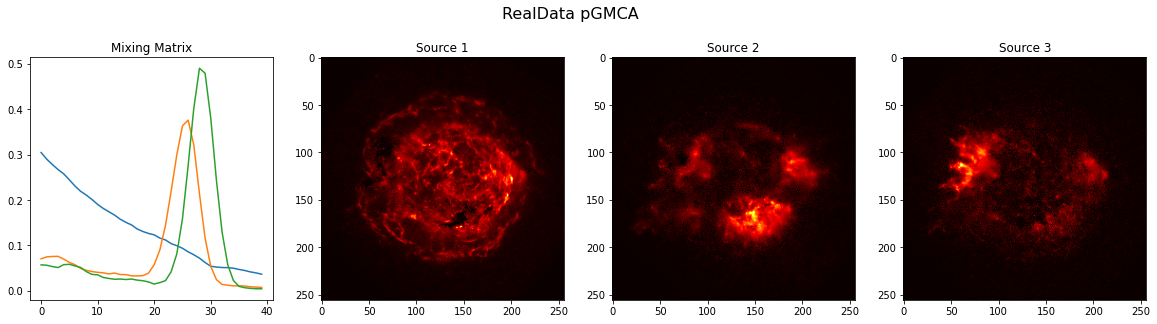

In [ ]:
S_est = S_est.reshape(n, 256, 256)
plotAS(A_est, np.fmax(S_est, 0)**0.5, "RealData pGMCA")

In [ ]:
S_est, A_est, criterions = pGMCA(LinModel, MixingMatrix, iter=150, iter_gmca=1000, iter_gfbs=2, iter_fista=20)

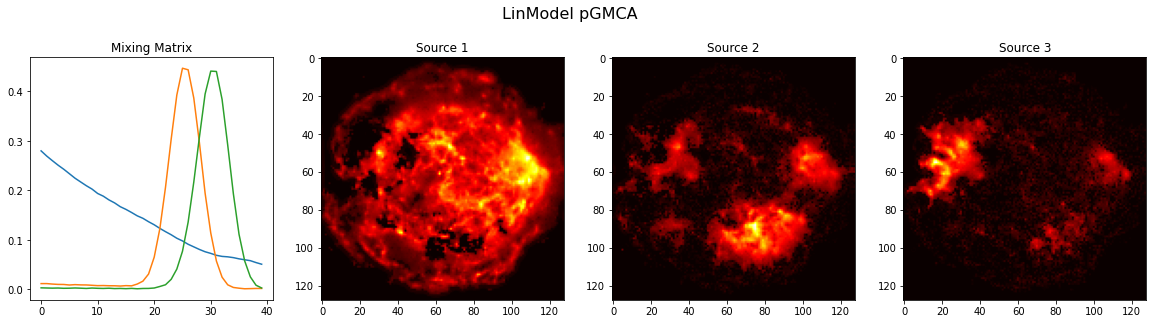

In [ ]:
S_est = S_est.reshape(n, 128, 128)
plotAS(A_est, np.fmax(S_est, 0)**0.5, "LinModel pGMCA")

Les résultats ci-dessus sont obtenus pour les jeux de données **LinModel** et **RealData**. Dans le cas du premier jeu de données, on remarque que l’approximation de la matrice de mélange est bien meilleure que celle obtenue par les méthodes précédentes. Les défauts évoqués dans le cas des algorithmes PALM et Minimum Volume NMF tels que le « creux » dans le spectre du synchrotron et les différences d’intensité entre les raies de Fer blue-shifted et red-shifted ne sont plus présents ou sont devenus négligeables. Ainsi, pour le jeu de données simulé, l’algorithme pGMCA fournit des résultats plus satisfaisants que les méthodes précédentes.
Cependant, les résultats pour le jeu de données **RealData** sont plus mitigés. L’algorithme pGMCA parvient à retrouver la structure globale des spectres d’émission des éléments étudiés mais de façon beaucoup moins précise que dans le cas du jeu de données **LinModel**.

Cela peut s’expliquer par le fait que le modèle de factorisation de matrices que l’on considère dans toute cette étude est linéaire ($\mathbf{X} = \mathbf{AS}$) alors que la vraie relation entre les observations et les sources est potentiellement non linéaire, de la forme $\mathbf{X} = f(\mathbf{AS})$.